In [83]:
!date

Fri Dec  6 09:34:30 PST 2019


In [1]:
!rm -rf BMGP_2020
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 741, done.
remote: Counting objects: 100% (445/445), done.
remote: Compressing objects: 100% (374/374), done.
remote: Total 741 (delta 189), reused 226 (delta 68), pack-reused 296
Receiving objects: 100% (741/741), 469.83 MiB | 18.80 MiB/s, done.
Resolving deltas: 100% (280/280), done.
Checking out files: 100% (152/152), done.


In [64]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
plt.rcParams.update({'font.size': 20})
%config InlineBackend.figure_format = 'retina'
colors = ["#e41a1c", "#377eb8"]

In [32]:
def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

In [30]:
import glob
import pandas as pd

def get_time(line):
    # returns milliseconds
    t = ":".join(line.split(":")[4:]).strip()
    hours, minutes, seconds = (["0", "0"] + t.split(":"))[-3:]
    hours = int(hours)
    minutes = int(minutes)
    seconds = float(seconds)
    ms = int(3600000 * hours + 60000 * minutes + 1000 * seconds)

    return ms
        
def get_mem(line):
    # returns bytes
    mem = int(line.split(':')[-1].strip())*1000
    return mem

def get_memtime(f):
    with open(f, 'r') as file:
        for idx, line in enumerate(file):
            if idx == 4:
                time = get_time(line)
            if idx == 9:
                mem = get_mem(line)
    return (mem, time)

def convert_memtime(files, step="align_count"):
    d = {}

    d[step] = {"time": [], "mem": []}

    mem = []
    time = []
    for f in files:
        m, t = get_memtime(f)
        mem.append(m)
        time.append(t)
    d[step]['time'] = time
    d[step]['mem'] = mem
    names = [f.split("/")[-3] for f in files]

    df = pd.DataFrame.from_dict({(i,j): d[i][j] 
                               for i in d.keys() 
                               for j in d[i].keys()})
    df.index = names
    return df
    

In [26]:
files = sorted(glob.glob(f'BMGP_2020/data/*/memtime/memtime_0.log'))
kb = convert_memtime(files, "align_count")

In [27]:
kb

align_count            
                 time         mem
10xCRISPR      245620  4196132000
10xFB          150700  4196132000
cellhash       213630  4196132000
clicktag        76000  4196132000
multiseq       227010  4196132000

In [28]:
files = sorted(glob.glob(f'BMGP_2020/data/*/memtime/memtime_1.log'))
ot = convert_memtime(files, "align_count")

In [29]:
ot

align_count             
                 time          mem
10xCRISPR     3798000  15237456000
10xFB          804660  14502036000
cellhash      5175000  15350040000
clicktag      3658000   6488268000
multiseq      3537020  19372888000

In [40]:
reads = {
    "10xCRISPR": 121_241_237,
    "10xFB": 39_096_673,
    "clicktag": 15_928_888,
    "cellhash": 74_219_921,
    "multiseq": 96_428_956
}

In [60]:
kb["nreads"] = kb.index.map(reads)
ot["nreads"] = ot.index.map(reads)

In [61]:
kb = kb.sort_values("nreads")
ot = ot.sort_values("nreads")

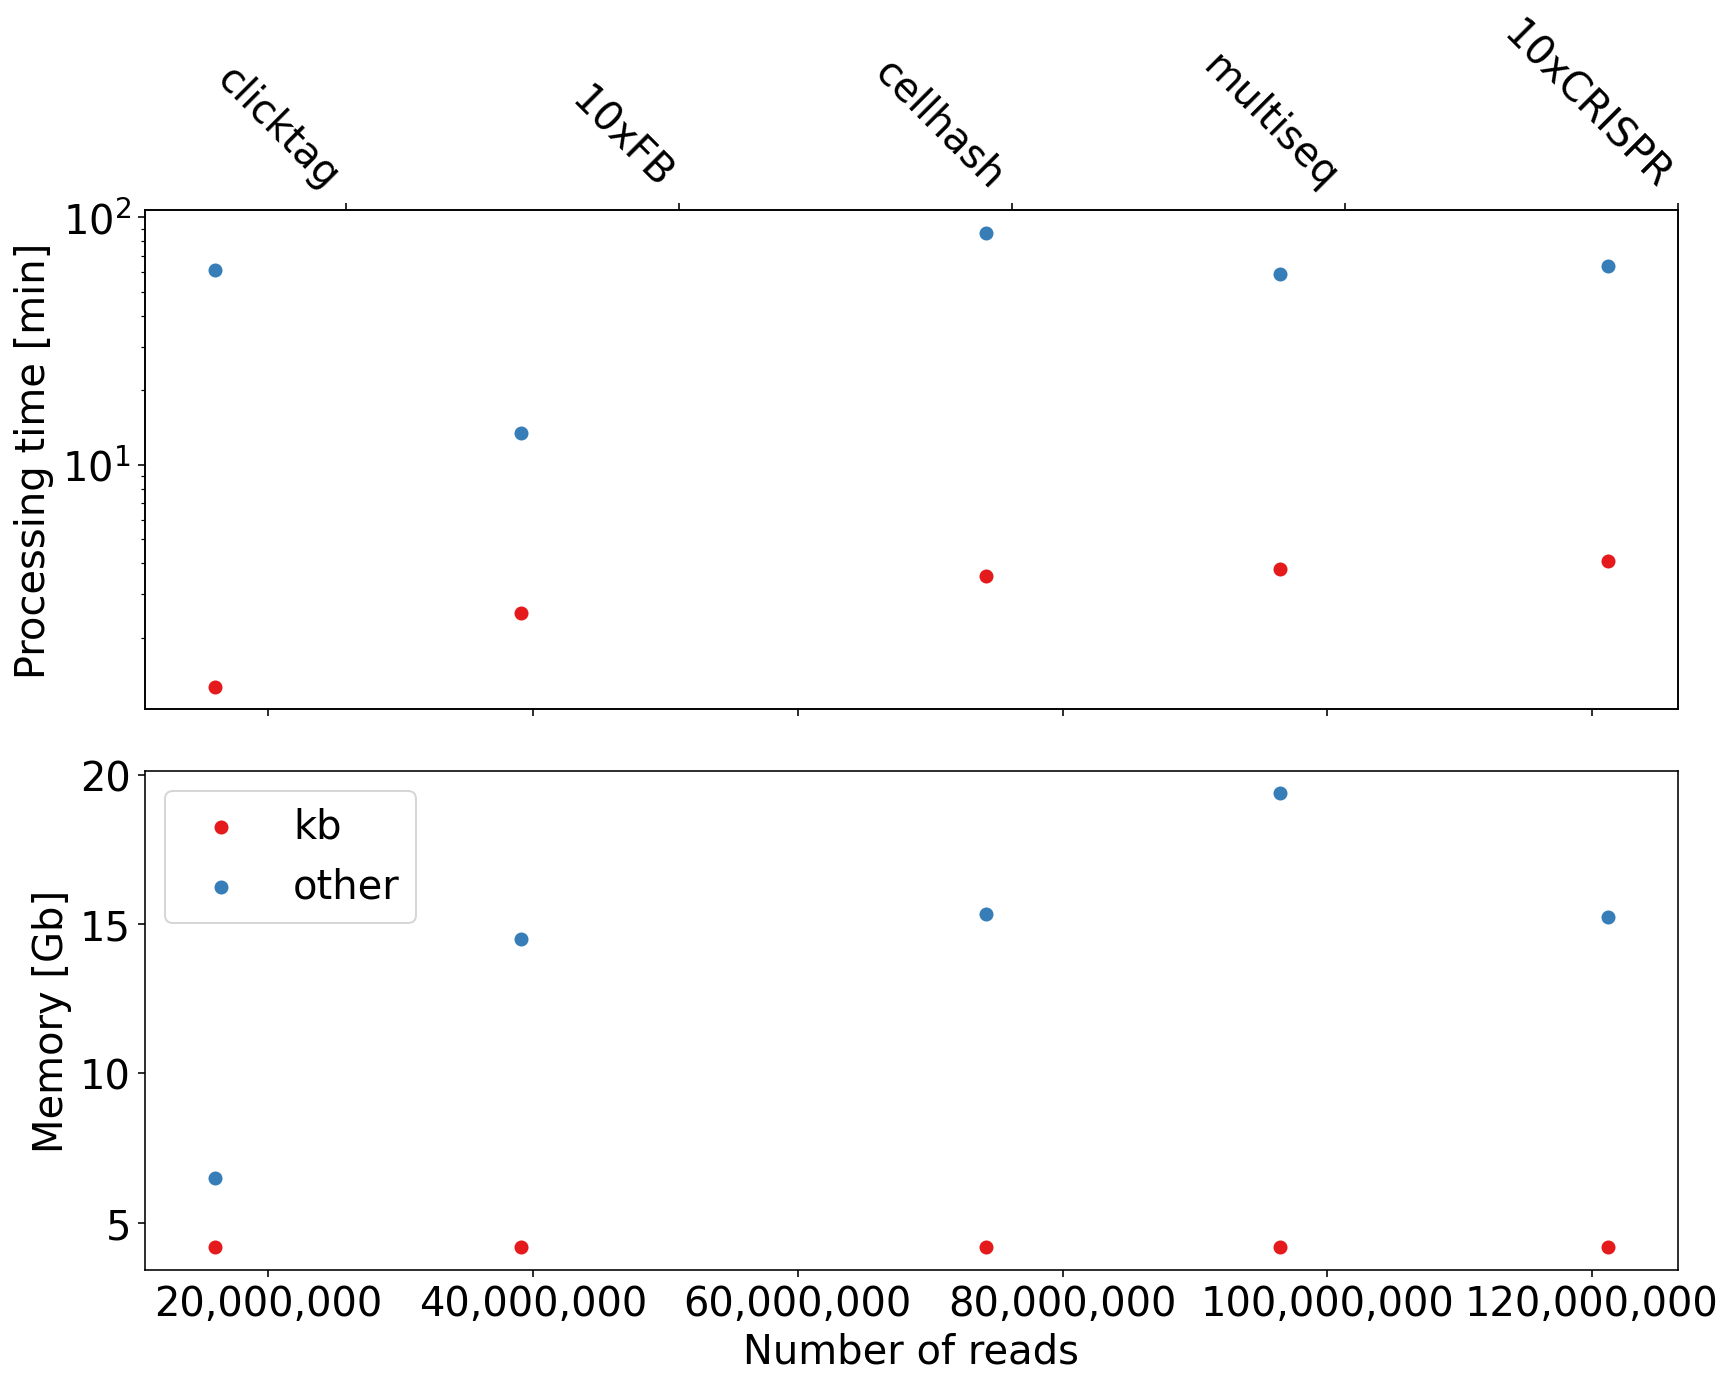

In [78]:
fig, axs = plt.subplots(figsize=(12.5,10), nrows=2)

scale = 1000*60

# time
ax = axs[0]
x = kb["nreads"]
y = kb["align_count"].time/scale
ax.scatter(x,y, label="kb", color=colors[0])

y = ot["align_count"].time/scale
ax.scatter(x,y, label="other", color=colors[1])


ax2 = ax.twiny()
ax2.set(**{
    "xticks": np.linspace(kb['nreads'].min(), kb['nreads'].max(), kb.shape[0]),
    "xticklabels": kb.index.values,
})

for label in ax2.get_xticklabels():
    label.set_rotation(-45)
    label.set_horizontalalignment("right")

ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax.set(**{
    "ylabel": "Processing time [min]",
    "yscale": "log",
    "xticklabels": []
})


# memory
ax = axs[1]
scale = 10**9
x = kb["nreads"]
y = kb["align_count"].mem/scale
ax.scatter(x,y, label="kb", color=colors[0])

y = ot["align_count"].mem/scale
ax.scatter(x,y, label="other", color=colors[1])

ax.set(**{
    "xlabel": "Number of reads",
    "ylabel": "Memory [Gb]"
})
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.legend()
fig.tight_layout()
fig.show()